In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import itertools

from torch.utils.data import DataLoader
from torch import nn
from sklearn.metrics import mean_absolute_error, median_absolute_error, mean_squared_error

sys.path.append("..")
from utils import metrics
from utils.data import TimeFusionDataset
from timefusion import TimeFusion
from utils.early_stopper import EarlyStopper

In [2]:
# Import data
train_data = pd.read_csv("../../datasets/electricity/train.csv").set_index("date")
test_data = pd.read_csv("../../datasets/electricity/test.csv").set_index("date")
train_data = train_data.iloc[:,:90]
test_data = test_data.iloc[:,:90]

# Normalize the signal power of each column
stds = train_data.std()
train_data /= stds
test_data /= stds

In [3]:
# Compute device
if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [4]:
context_length = 96
prediction_length = 24

# Create datasets
train_dataset = TimeFusionDataset(
    data = train_data.iloc[:int(0.9*len(train_data))],
    context_length = context_length,
)
train_dataset.add_timestamp_encodings()

val_dataset = TimeFusionDataset(
    data = train_data.iloc[int(0.9*len(train_data)):],
    context_length = context_length,
)
val_dataset.add_timestamp_encodings()

test_dataset = TimeFusionDataset(
    data = test_data,
    context_length = context_length,
)
test_dataset.add_timestamp_encodings()

train_loader = DataLoader(
    dataset = train_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

val_loader = DataLoader(
    dataset = val_dataset,
    shuffle = True,
    num_workers = 4,
    batch_size = 128,
)

In [5]:
predictor = TimeFusion(
    input_size = train_dataset.data.shape[1],
    output_size = train_data.shape[1],
    rnn_layers = 2,
    rnn_hidden = 60,
    residual_layers = 4,
    residual_size = 60 + train_data.shape[1],
    residual_hidden = 100,
    scaling = True,
    device = device
)

print("Number of trainable parameters:",sum(p.numel() for p in predictor.parameters()))

/rds/general/user/ejh19/home/Final-Year-Project/TimeFusion/examples/../utils/diffusion.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.bar_alphas = torch.tensor(


Number of trainable parameters: 230560


In [6]:
predictor.modules

<bound method Module.modules of TimeFusion(
  (scaler): MeanScaler()
  (epsilon_theta): EpsilonTheta(
    (embedding): DiffusionEmbedding(
      (linear1): Linear(in_features=32, out_features=60, bias=True)
      (tanh): Tanh()
      (linear2): Linear(in_features=60, out_features=60, bias=True)
    )
    (rnn): LSTM(98, 60, num_layers=2, batch_first=True)
    (residuals): Sequential(
      (0): Linear(in_features=150, out_features=150, bias=True)
      (1): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (2): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
        (relu): ReLU()
        (linear2): Linear(in_features=100, out_features=150, bias=True)
        (tanh): Tanh()
      )
      (3): ResidualBlock(
        (linear1): Linear(in_features=150, out_features=100, bias=True)
   

In [7]:
optimizer = torch.optim.Adam(params=predictor.parameters(),lr=4e-4)
lr_scheduler = torch.optim.lr_scheduler.LinearLR(optimizer, start_factor=1, end_factor=0.01, total_iters=120)

predictor.train_network(
    train_loader = train_loader,
    epochs=120,
    val_loader = val_loader,
    val_metrics= {
        "Val MAE": nn.L1Loss(),
    },
    optimizer = optimizer,
    lr_scheduler= lr_scheduler,
    early_stopper=EarlyStopper(patience=20),
    save_weights = True,
    weight_folder = "weights/electricity"
)

Epoch: 1/120: 100%|██████████| 169/169 [00:02<00:00, 79.12batch/s, Training loss=0.7391]


Val MAE: 0.5754 , val_loss: 0.5312 , 


Epoch: 2/120: 100%|██████████| 169/169 [00:02<00:00, 71.69batch/s, Training loss=0.4278]


Val MAE: 0.4606 , val_loss: 0.3588 , 


Epoch: 3/120: 100%|██████████| 169/169 [00:02<00:00, 72.99batch/s, Training loss=0.3079]


Val MAE: 0.3969 , val_loss: 0.2833 , 


Epoch: 4/120: 100%|██████████| 169/169 [00:02<00:00, 71.92batch/s, Training loss=0.2511]


Val MAE: 0.3542 , val_loss: 0.2383 , 


Epoch: 5/120: 100%|██████████| 169/169 [00:02<00:00, 72.81batch/s, Training loss=0.2247]


Val MAE: 0.3402 , val_loss: 0.2222 , 


Epoch: 6/120: 100%|██████████| 169/169 [00:02<00:00, 71.04batch/s, Training loss=0.2139]


Val MAE: 0.3446 , val_loss: 0.2397 , 


Epoch: 7/120: 100%|██████████| 169/169 [00:02<00:00, 71.86batch/s, Training loss=0.2031]


Val MAE: 0.3245 , val_loss: 0.2098 , 


Epoch: 8/120: 100%|██████████| 169/169 [00:02<00:00, 71.67batch/s, Training loss=0.1935]


Val MAE: 0.3227 , val_loss: 0.2105 , 


Epoch: 9/120: 100%|██████████| 169/169 [00:02<00:00, 70.79batch/s, Training loss=0.1882]


Val MAE: 0.3053 , val_loss: 0.1932 , 


Epoch: 10/120: 100%|██████████| 169/169 [00:02<00:00, 72.40batch/s, Training loss=0.1764]


Val MAE: 0.2937 , val_loss: 0.1801 , 


Epoch: 11/120: 100%|██████████| 169/169 [00:02<00:00, 73.22batch/s, Training loss=0.1733]


Val MAE: 0.2951 , val_loss: 0.1844 , 


Epoch: 12/120: 100%|██████████| 169/169 [00:02<00:00, 75.04batch/s, Training loss=0.1702]


Val MAE: 0.2924 , val_loss: 0.1850 , 


Epoch: 13/120: 100%|██████████| 169/169 [00:02<00:00, 74.48batch/s, Training loss=0.1650]


Val MAE: 0.2813 , val_loss: 0.1701 , 


Epoch: 14/120: 100%|██████████| 169/169 [00:02<00:00, 74.51batch/s, Training loss=0.1597]


Val MAE: 0.2778 , val_loss: 0.1715 , 


Epoch: 15/120: 100%|██████████| 169/169 [00:02<00:00, 75.19batch/s, Training loss=0.1550]


Val MAE: 0.2782 , val_loss: 0.1733 , 


Epoch: 16/120: 100%|██████████| 169/169 [00:02<00:00, 76.58batch/s, Training loss=0.1550]


Val MAE: 0.2721 , val_loss: 0.1650 , 


Epoch: 17/120: 100%|██████████| 169/169 [00:02<00:00, 74.05batch/s, Training loss=0.1496]


Val MAE: 0.2635 , val_loss: 0.1548 , 


Epoch: 18/120: 100%|██████████| 169/169 [00:02<00:00, 74.01batch/s, Training loss=0.1485]


Val MAE: 0.2596 , val_loss: 0.1554 , 


Epoch: 19/120: 100%|██████████| 169/169 [00:02<00:00, 74.84batch/s, Training loss=0.1444]


Val MAE: 0.2591 , val_loss: 0.1547 , 


Epoch: 20/120: 100%|██████████| 169/169 [00:02<00:00, 74.67batch/s, Training loss=0.1445]


Val MAE: 0.2583 , val_loss: 0.1557 , 


Epoch: 21/120: 100%|██████████| 169/169 [00:02<00:00, 75.61batch/s, Training loss=0.1420]


Val MAE: 0.2587 , val_loss: 0.1587 , 


Epoch: 22/120: 100%|██████████| 169/169 [00:02<00:00, 74.91batch/s, Training loss=0.1366]


Val MAE: 0.2520 , val_loss: 0.1522 , 


Epoch: 23/120: 100%|██████████| 169/169 [00:02<00:00, 73.81batch/s, Training loss=0.1381]


Val MAE: 0.2403 , val_loss: 0.1367 , 


Epoch: 24/120: 100%|██████████| 169/169 [00:02<00:00, 75.66batch/s, Training loss=0.1376]


Val MAE: 0.2489 , val_loss: 0.1473 , 


Epoch: 25/120: 100%|██████████| 169/169 [00:02<00:00, 75.85batch/s, Training loss=0.1356]


Val MAE: 0.2436 , val_loss: 0.1424 , 


Epoch: 26/120: 100%|██████████| 169/169 [00:02<00:00, 73.76batch/s, Training loss=0.1359]


Val MAE: 0.2372 , val_loss: 0.1362 , 


Epoch: 27/120: 100%|██████████| 169/169 [00:02<00:00, 74.05batch/s, Training loss=0.1336]


Val MAE: 0.2406 , val_loss: 0.1426 , 


Epoch: 28/120: 100%|██████████| 169/169 [00:02<00:00, 75.94batch/s, Training loss=0.1317]


Val MAE: 0.2446 , val_loss: 0.1485 , 


Epoch: 29/120: 100%|██████████| 169/169 [00:02<00:00, 74.88batch/s, Training loss=0.1290]


Val MAE: 0.2440 , val_loss: 0.1506 , 


Epoch: 30/120: 100%|██████████| 169/169 [00:02<00:00, 74.00batch/s, Training loss=0.1261]


Val MAE: 0.2284 , val_loss: 0.1299 , 


Epoch: 31/120: 100%|██████████| 169/169 [00:02<00:00, 74.62batch/s, Training loss=0.1303]


Val MAE: 0.2354 , val_loss: 0.1412 , 


Epoch: 32/120: 100%|██████████| 169/169 [00:02<00:00, 75.23batch/s, Training loss=0.1250]


Val MAE: 0.2365 , val_loss: 0.1389 , 


Epoch: 33/120: 100%|██████████| 169/169 [00:02<00:00, 78.45batch/s, Training loss=0.1265]


Val MAE: 0.2393 , val_loss: 0.1478 , 


Epoch: 34/120: 100%|██████████| 169/169 [00:02<00:00, 76.80batch/s, Training loss=0.1280]


Val MAE: 0.2324 , val_loss: 0.1375 , 


Epoch: 35/120: 100%|██████████| 169/169 [00:02<00:00, 74.59batch/s, Training loss=0.1249]


Val MAE: 0.2229 , val_loss: 0.1265 , 


Epoch: 36/120: 100%|██████████| 169/169 [00:02<00:00, 74.78batch/s, Training loss=0.1240]


Val MAE: 0.2272 , val_loss: 0.1346 , 


Epoch: 37/120: 100%|██████████| 169/169 [00:02<00:00, 73.56batch/s, Training loss=0.1216]


Val MAE: 0.2318 , val_loss: 0.1378 , 


Epoch: 38/120: 100%|██████████| 169/169 [00:02<00:00, 73.81batch/s, Training loss=0.1218]


Val MAE: 0.2260 , val_loss: 0.1328 , 


Epoch: 39/120: 100%|██████████| 169/169 [00:02<00:00, 73.92batch/s, Training loss=0.1243]


Val MAE: 0.2257 , val_loss: 0.1344 , 


Epoch: 40/120: 100%|██████████| 169/169 [00:02<00:00, 73.81batch/s, Training loss=0.1208]


Val MAE: 0.2200 , val_loss: 0.1273 , 


Epoch: 41/120: 100%|██████████| 169/169 [00:02<00:00, 74.78batch/s, Training loss=0.1210]


Val MAE: 0.2284 , val_loss: 0.1384 , 


Epoch: 42/120: 100%|██████████| 169/169 [00:02<00:00, 76.29batch/s, Training loss=0.1210]


Val MAE: 0.2274 , val_loss: 0.1369 , 


Epoch: 43/120: 100%|██████████| 169/169 [00:02<00:00, 75.41batch/s, Training loss=0.1228]


Val MAE: 0.2223 , val_loss: 0.1265 , 


Epoch: 44/120: 100%|██████████| 169/169 [00:02<00:00, 74.57batch/s, Training loss=0.1216]


Val MAE: 0.2291 , val_loss: 0.1407 , 


Epoch: 45/120: 100%|██████████| 169/169 [00:02<00:00, 74.88batch/s, Training loss=0.1190]


Val MAE: 0.2156 , val_loss: 0.1248 , 


Epoch: 46/120: 100%|██████████| 169/169 [00:02<00:00, 72.66batch/s, Training loss=0.1187]


Val MAE: 0.2181 , val_loss: 0.1293 , 


Epoch: 47/120: 100%|██████████| 169/169 [00:02<00:00, 73.04batch/s, Training loss=0.1163]


Val MAE: 0.2129 , val_loss: 0.1219 , 


Epoch: 48/120: 100%|██████████| 169/169 [00:02<00:00, 72.00batch/s, Training loss=0.1163]


Val MAE: 0.2153 , val_loss: 0.1263 , 


Epoch: 49/120: 100%|██████████| 169/169 [00:02<00:00, 74.67batch/s, Training loss=0.1171]


Val MAE: 0.2153 , val_loss: 0.1253 , 


Epoch: 50/120: 100%|██████████| 169/169 [00:02<00:00, 76.89batch/s, Training loss=0.1180]


Val MAE: 0.2201 , val_loss: 0.1277 , 


Epoch: 51/120: 100%|██████████| 169/169 [00:02<00:00, 74.73batch/s, Training loss=0.1152]


Val MAE: 0.2179 , val_loss: 0.1264 , 


Epoch: 52/120: 100%|██████████| 169/169 [00:02<00:00, 73.50batch/s, Training loss=0.1161]


Val MAE: 0.2240 , val_loss: 0.1340 , 


Epoch: 53/120: 100%|██████████| 169/169 [00:02<00:00, 75.68batch/s, Training loss=0.1149]


Val MAE: 0.2166 , val_loss: 0.1274 , 


Epoch: 54/120: 100%|██████████| 169/169 [00:02<00:00, 75.93batch/s, Training loss=0.1155]


Val MAE: 0.2132 , val_loss: 0.1245 , 


Epoch: 55/120: 100%|██████████| 169/169 [00:02<00:00, 75.50batch/s, Training loss=0.1168]


Val MAE: 0.2137 , val_loss: 0.1243 , 


Epoch: 56/120: 100%|██████████| 169/169 [00:02<00:00, 76.50batch/s, Training loss=0.1177]


Val MAE: 0.2241 , val_loss: 0.1404 , 


Epoch: 57/120: 100%|██████████| 169/169 [00:02<00:00, 72.97batch/s, Training loss=0.1120]


Val MAE: 0.2229 , val_loss: 0.1387 , 


Epoch: 58/120: 100%|██████████| 169/169 [00:02<00:00, 71.86batch/s, Training loss=0.1140]


Val MAE: 0.2122 , val_loss: 0.1221 , 


Epoch: 59/120: 100%|██████████| 169/169 [00:02<00:00, 71.04batch/s, Training loss=0.1130]


Val MAE: 0.2182 , val_loss: 0.1328 , 


Epoch: 60/120: 100%|██████████| 169/169 [00:02<00:00, 74.82batch/s, Training loss=0.1113]


Val MAE: 0.2077 , val_loss: 0.1212 , 


Epoch: 61/120: 100%|██████████| 169/169 [00:02<00:00, 74.50batch/s, Training loss=0.1131]


Val MAE: 0.2129 , val_loss: 0.1235 , 


Epoch: 62/120: 100%|██████████| 169/169 [00:02<00:00, 73.44batch/s, Training loss=0.1139]


Val MAE: 0.2128 , val_loss: 0.1262 , 


Epoch: 63/120: 100%|██████████| 169/169 [00:02<00:00, 73.41batch/s, Training loss=0.1129]


Val MAE: 0.2164 , val_loss: 0.1331 , 


Epoch: 64/120: 100%|██████████| 169/169 [00:02<00:00, 74.90batch/s, Training loss=0.1124]


Val MAE: 0.2097 , val_loss: 0.1238 , 


Epoch: 65/120: 100%|██████████| 169/169 [00:02<00:00, 75.97batch/s, Training loss=0.1124]


Val MAE: 0.2161 , val_loss: 0.1292 , 


Epoch: 66/120: 100%|██████████| 169/169 [00:02<00:00, 75.28batch/s, Training loss=0.1135]


Val MAE: 0.2130 , val_loss: 0.1264 , 


Epoch: 67/120: 100%|██████████| 169/169 [00:02<00:00, 74.52batch/s, Training loss=0.1129]


Val MAE: 0.2064 , val_loss: 0.1191 , 


Epoch: 68/120: 100%|██████████| 169/169 [00:02<00:00, 72.86batch/s, Training loss=0.1107]


Val MAE: 0.2014 , val_loss: 0.1138 , 


Epoch: 69/120: 100%|██████████| 169/169 [00:02<00:00, 73.44batch/s, Training loss=0.1068]


Val MAE: 0.2131 , val_loss: 0.1297 , 


Epoch: 70/120: 100%|██████████| 169/169 [00:02<00:00, 72.17batch/s, Training loss=0.1100]


Val MAE: 0.2094 , val_loss: 0.1245 , 


Epoch: 71/120: 100%|██████████| 169/169 [00:02<00:00, 72.10batch/s, Training loss=0.1110]


Val MAE: 0.2072 , val_loss: 0.1223 , 


Epoch: 72/120: 100%|██████████| 169/169 [00:02<00:00, 73.84batch/s, Training loss=0.1097]


Val MAE: 0.2051 , val_loss: 0.1190 , 


Epoch: 73/120: 100%|██████████| 169/169 [00:02<00:00, 72.58batch/s, Training loss=0.1113]


Val MAE: 0.2095 , val_loss: 0.1235 , 


Epoch: 74/120: 100%|██████████| 169/169 [00:02<00:00, 71.69batch/s, Training loss=0.1098]


Val MAE: 0.2145 , val_loss: 0.1306 , 


Epoch: 75/120: 100%|██████████| 169/169 [00:02<00:00, 73.01batch/s, Training loss=0.1114]


Val MAE: 0.2126 , val_loss: 0.1308 , 


Epoch: 76/120: 100%|██████████| 169/169 [00:02<00:00, 73.00batch/s, Training loss=0.1091]


Val MAE: 0.2001 , val_loss: 0.1135 , 


Epoch: 77/120: 100%|██████████| 169/169 [00:02<00:00, 73.57batch/s, Training loss=0.1084]


Val MAE: 0.1992 , val_loss: 0.1134 , 


Epoch: 78/120: 100%|██████████| 169/169 [00:02<00:00, 72.79batch/s, Training loss=0.1056]


Val MAE: 0.2069 , val_loss: 0.1215 , 


Epoch: 79/120: 100%|██████████| 169/169 [00:02<00:00, 72.67batch/s, Training loss=0.1088]


Val MAE: 0.2117 , val_loss: 0.1313 , 


Epoch: 80/120: 100%|██████████| 169/169 [00:02<00:00, 74.67batch/s, Training loss=0.1070]


Val MAE: 0.2146 , val_loss: 0.1327 , 


Epoch: 81/120: 100%|██████████| 169/169 [00:02<00:00, 75.77batch/s, Training loss=0.1054]


Val MAE: 0.1984 , val_loss: 0.1149 , 


Epoch: 82/120: 100%|██████████| 169/169 [00:02<00:00, 77.71batch/s, Training loss=0.1099]


Val MAE: 0.2087 , val_loss: 0.1252 , 


Epoch: 83/120: 100%|██████████| 169/169 [00:02<00:00, 77.95batch/s, Training loss=0.1077]


Val MAE: 0.2019 , val_loss: 0.1183 , 


Epoch: 84/120: 100%|██████████| 169/169 [00:02<00:00, 78.52batch/s, Training loss=0.1080]


Val MAE: 0.2014 , val_loss: 0.1182 , 


Epoch: 85/120: 100%|██████████| 169/169 [00:02<00:00, 77.66batch/s, Training loss=0.1059]


Val MAE: 0.2001 , val_loss: 0.1165 , 


Epoch: 86/120: 100%|██████████| 169/169 [00:02<00:00, 77.29batch/s, Training loss=0.1066]


Val MAE: 0.2101 , val_loss: 0.1247 , 


Epoch: 87/120: 100%|██████████| 169/169 [00:02<00:00, 72.76batch/s, Training loss=0.1078]


Val MAE: 0.2046 , val_loss: 0.1243 , 


Epoch: 88/120: 100%|██████████| 169/169 [00:02<00:00, 74.21batch/s, Training loss=0.1077]


Val MAE: 0.2106 , val_loss: 0.1450 , 


Epoch: 89/120: 100%|██████████| 169/169 [00:02<00:00, 74.76batch/s, Training loss=0.1071]


Val MAE: 0.1971 , val_loss: 0.1141 , 


Epoch: 90/120: 100%|██████████| 169/169 [00:02<00:00, 75.78batch/s, Training loss=0.1054]


Val MAE: 0.2008 , val_loss: 0.1198 , 


Epoch: 91/120: 100%|██████████| 169/169 [00:02<00:00, 72.76batch/s, Training loss=0.1054]


Val MAE: 0.2066 , val_loss: 0.1218 , 


Epoch: 92/120: 100%|██████████| 169/169 [00:02<00:00, 72.86batch/s, Training loss=0.1060]


Val MAE: 0.1970 , val_loss: 0.1141 , 


Epoch: 93/120: 100%|██████████| 169/169 [00:02<00:00, 74.62batch/s, Training loss=0.1058]


Val MAE: 0.1964 , val_loss: 0.1113 , 


Epoch: 94/120: 100%|██████████| 169/169 [00:02<00:00, 74.46batch/s, Training loss=0.1069]


Val MAE: 0.2011 , val_loss: 0.1166 , 


Epoch: 95/120: 100%|██████████| 169/169 [00:02<00:00, 72.70batch/s, Training loss=0.1072]


Val MAE: 0.2076 , val_loss: 0.1269 , 


Epoch: 96/120: 100%|██████████| 169/169 [00:02<00:00, 73.95batch/s, Training loss=0.1052]


Val MAE: 0.1921 , val_loss: 0.1071 , 


Epoch: 97/120: 100%|██████████| 169/169 [00:02<00:00, 73.23batch/s, Training loss=0.1050]


Val MAE: 0.2053 , val_loss: 0.1266 , 


Epoch: 98/120: 100%|██████████| 169/169 [00:02<00:00, 73.92batch/s, Training loss=0.1062]


Val MAE: 0.2063 , val_loss: 0.1272 , 


Epoch: 99/120: 100%|██████████| 169/169 [00:02<00:00, 74.63batch/s, Training loss=0.1035]


Val MAE: 0.1895 , val_loss: 0.1049 , 


Epoch: 100/120: 100%|██████████| 169/169 [00:02<00:00, 74.80batch/s, Training loss=0.1052]


Val MAE: 0.2007 , val_loss: 0.1181 , 


Epoch: 101/120: 100%|██████████| 169/169 [00:02<00:00, 72.55batch/s, Training loss=0.1069]


Val MAE: 0.2059 , val_loss: 0.1368 , 


Epoch: 102/120: 100%|██████████| 169/169 [00:02<00:00, 74.19batch/s, Training loss=0.1036]


Val MAE: 0.2037 , val_loss: 0.1237 , 


Epoch: 103/120: 100%|██████████| 169/169 [00:02<00:00, 77.35batch/s, Training loss=0.1027]


Val MAE: 0.2018 , val_loss: 0.1218 , 


Epoch: 104/120: 100%|██████████| 169/169 [00:02<00:00, 77.28batch/s, Training loss=0.1034]


Val MAE: 0.1956 , val_loss: 0.1156 , 


Epoch: 105/120: 100%|██████████| 169/169 [00:02<00:00, 74.22batch/s, Training loss=0.1073]


Val MAE: 0.1928 , val_loss: 0.1111 , 


Epoch: 106/120: 100%|██████████| 169/169 [00:02<00:00, 74.51batch/s, Training loss=0.1053]


Val MAE: 0.2023 , val_loss: 0.1249 , 


Epoch: 107/120: 100%|██████████| 169/169 [00:02<00:00, 74.22batch/s, Training loss=0.1046]


Val MAE: 0.1889 , val_loss: 0.1083 , 


Epoch: 108/120: 100%|██████████| 169/169 [00:02<00:00, 74.18batch/s, Training loss=0.1042]


Val MAE: 0.1909 , val_loss: 0.1103 , 


Epoch: 109/120: 100%|██████████| 169/169 [00:02<00:00, 75.06batch/s, Training loss=0.1038]


Val MAE: 0.1934 , val_loss: 0.1132 , 


Epoch: 110/120: 100%|██████████| 169/169 [00:02<00:00, 79.06batch/s, Training loss=0.1026]


Val MAE: 0.1975 , val_loss: 0.1167 , 


Epoch: 111/120: 100%|██████████| 169/169 [00:02<00:00, 78.21batch/s, Training loss=0.1066]


Val MAE: 0.1878 , val_loss: 0.1057 , 


Epoch: 112/120: 100%|██████████| 169/169 [00:02<00:00, 75.71batch/s, Training loss=0.1036]


Val MAE: 0.2066 , val_loss: 0.1297 , 


Epoch: 113/120: 100%|██████████| 169/169 [00:02<00:00, 73.72batch/s, Training loss=0.1043]


Val MAE: 0.1928 , val_loss: 0.1145 , 


Epoch: 114/120: 100%|██████████| 169/169 [00:02<00:00, 72.52batch/s, Training loss=0.1029]


Val MAE: 0.1944 , val_loss: 0.1160 , 


Epoch: 115/120: 100%|██████████| 169/169 [00:02<00:00, 75.33batch/s, Training loss=0.1036]


Val MAE: 0.1886 , val_loss: 0.1087 , 


Epoch: 116/120: 100%|██████████| 169/169 [00:02<00:00, 76.78batch/s, Training loss=0.1041]


Val MAE: 0.1942 , val_loss: 0.1149 , 


Epoch: 117/120: 100%|██████████| 169/169 [00:02<00:00, 73.34batch/s, Training loss=0.1014]


Val MAE: 0.1995 , val_loss: 0.1212 , 


Epoch: 118/120: 100%|██████████| 169/169 [00:02<00:00, 72.14batch/s, Training loss=0.0999]


Val MAE: 0.1960 , val_loss: 0.1298 , 


Epoch: 119/120: 100%|██████████| 169/169 [00:02<00:00, 72.10batch/s, Training loss=0.1005]


Val MAE: 0.1935 , val_loss: 0.1154 , 


In [8]:
# Load weights as an alternative to training
# predictor.load_state_dict(torch.load("weights/electricity/2023-05-24-18-26-53"))
# predictor.eval()

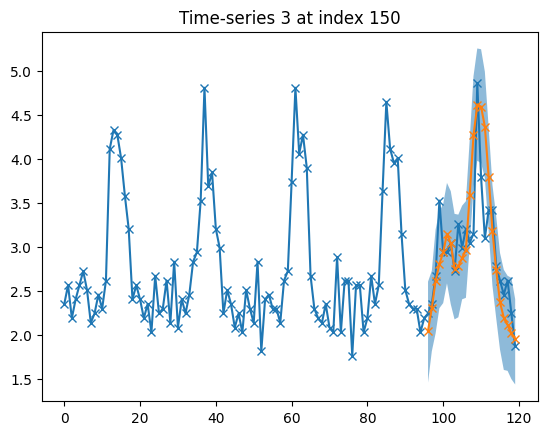

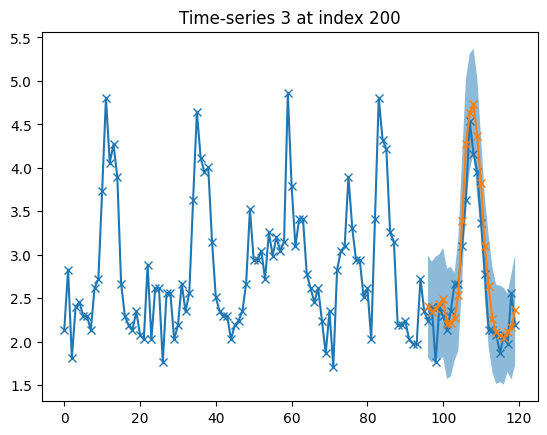

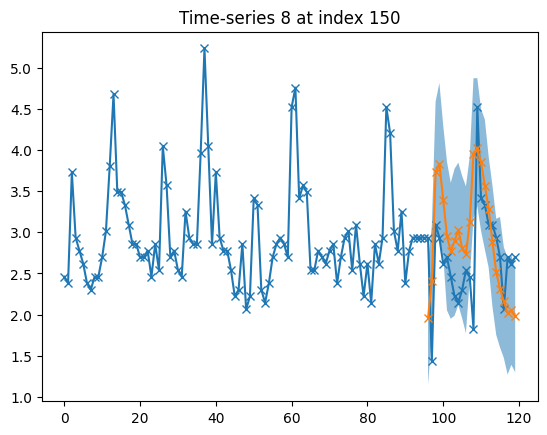

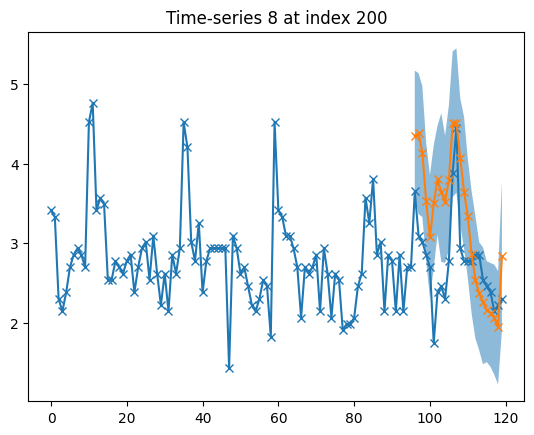

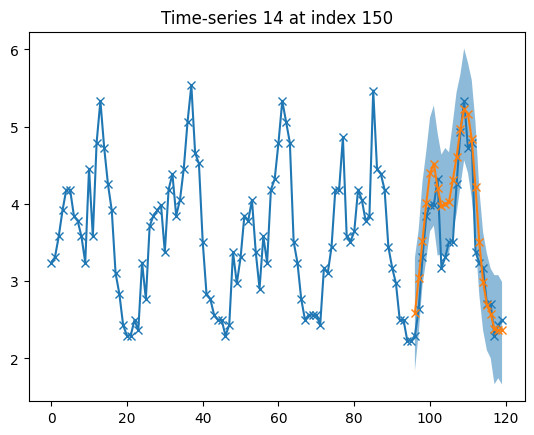

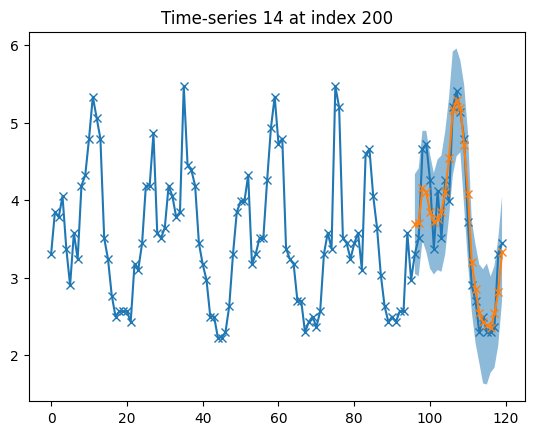

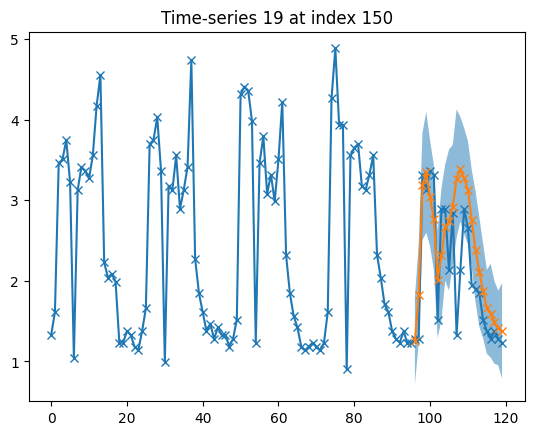

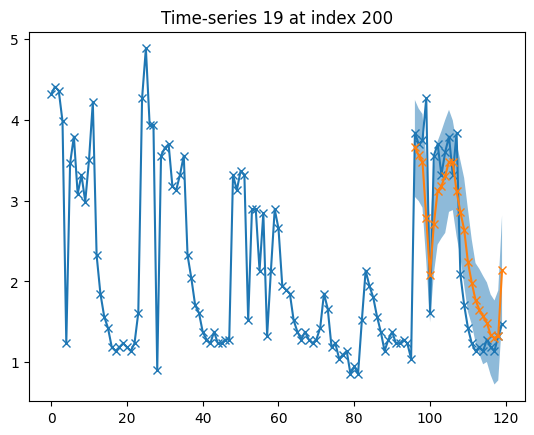

In [9]:
# Sample from model
indices = [150,200]

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu()

# Sort samples in ascending order
samples = samples.permute(0,2,3,1).flatten(start_dim=0,end_dim=2).sort()[0].reshape(samples.shape[0],samples.shape[2],samples.shape[3],-1).permute(0,3,1,2)

# Plot some predictions
confidence = 0.9
for ts, i in itertools.product([3,8,14,19],range(len(indices))):
    plt.figure()
    plt.title(f"Time-series {ts} at index {indices[i]}")
    plt.plot(test_dataset.tensor_data[indices[i]:indices[i]+context_length+prediction_length,ts],"-x")
    plt.plot(list(range(context_length,context_length+prediction_length)),torch.mean(samples[i,:,ts],dim = 0),"-x")
    plt.fill_between(list(range(context_length,context_length+prediction_length)), samples[i,int(confidence*samples.shape[1]),ts], samples[i,int((1-confidence)*samples.shape[1]),ts],alpha=0.5)
    #plt.savefig(f"images/no_shift_{idx}_{ts}.png")

In [10]:
# Make samples and extract realisations for last 14 days of test dataset
indices = list(range(0, 24*14, 24))

samples = predictor.sample(
    data = test_dataset,
    indices = indices,
    prediction_length = prediction_length,
    num_samples = 128,
    batch_size = 128,
)
samples = samples.cpu().numpy()


realisations = []
for idx in indices:
    realisations.append(
        test_data.values[context_length + idx:context_length + idx + prediction_length].T
    )
realisations = np.stack(realisations)


In [11]:
# Calculate metrics
mean_predictions = samples.mean(axis=1)

# MSE, MAE, MDAE
mse = mean_squared_error(realisations[0,:,10].flatten(), mean_predictions[0,:,10].flatten())
mae = mean_absolute_error(realisations.flatten(), mean_predictions.flatten())
mdae = median_absolute_error(realisations.flatten(), mean_predictions.flatten())
print("MSE:", mse, "MAE:", mae, "MDAE:", mdae)

# CRPS_sum and Variogram_score
crps_sum = np.mean([metrics.crps_sum(samples[i], realisations[i]) for i in range(realisations.shape[0])])
variogram_score = np.mean([metrics.variogram_score(samples[i], realisations[i], weights="local", window_size=3) for i in range(realisations.shape[0])])
print("CRPS_sum:", crps_sum, "Variogram_score:", variogram_score)

MSE: 0.23938916386332357 MAE: 0.3508972146427354 MDAE: 0.2521903585974199
CRPS_sum: 10.596966705151967 Variogram_score: 0.07737289062008075
